In [ ]:
%matplotlib inline
import os
import numpy as np
import glob
import xarray as xr
import pdb
from pathlib import Path
import pandas as pd
import dask
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime
from matplotlib.colors import ListedColormap
from skimage.filters import sobel
from skimage import feature
from skimage.morphology import disk, binary_dilation, binary_erosion
from scipy import ndimage
import rioxarray
from skimage.morphology import remove_small_objects

In [100]:
def sea_ice_edging(da, threshold=15):
    # threshold data, default at 15%, converts data to boolean type
    # thresh = da > threshold
    # fill gaps in data
    
    filled = ndimage.binary_fill_holes(da)
    filled = remove_small_objects(filled)

    # canny filter for edge detection
    edge = feature.canny(filled)
    # fill small gaps in data with dilation
    # edge = binary_dilation(edge, selem=disk(2)
    edge = binary_dilation(edge, footprint=disk(1))
    return edge

## Ice edge calculation

In [ ]:
# This consumes the output of artist_aggregator
filename = '/g/data/jk72/MIZ/processed/asi2_monthly.nc'
monthly_resample = xr.open_dataset(filename)

In [79]:
# fill na and threshold for greater than 15% conc
monthly_resample_threshold = monthly_resample['conc'].fillna(15) >= 15

In [101]:
monthly_edge = monthly_resample_threshold.groupby('time').apply(sea_ice_edging)
monthly_edge = monthly_edge.to_dataset(name='edge')
# monthly_edge = xr.open_dataset('/g/data/jk72/MIZ/processed/monthly_sea_ice_edge_AMSR2012-2020.nc')

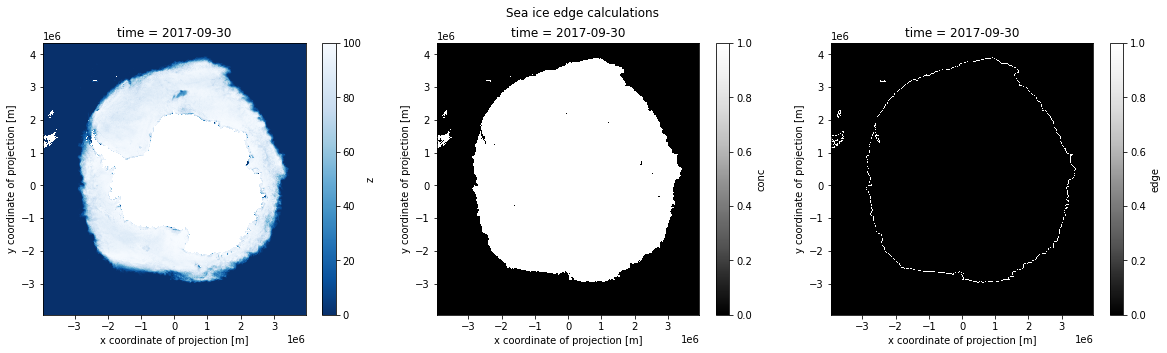

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Sea ice edge calculations')
time = '2017-09-30'
monthly_resample['conc'].sel(time=time).plot(cmap='Blues_r', ax=ax1)
monthly_resample_threshold.sel(time=time).plot(ax=ax2, cmap='Greys_r')
monthly_edge['edge'].sel(time=time).plot(ax=ax3, cmap='Greys_r')
# plt.savefig('/g/data/jk72/sc0554/miz/bremen_ice_edge_process.png')

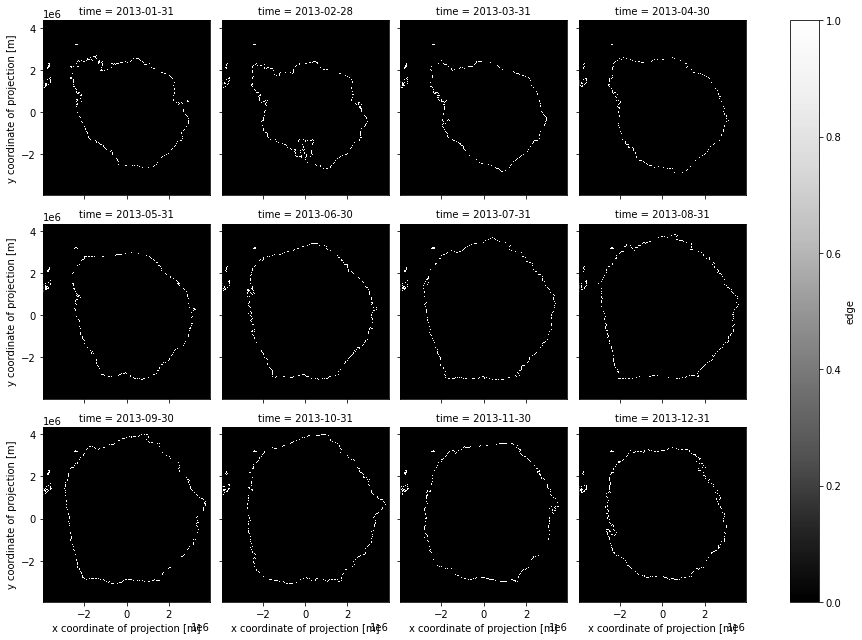

In [103]:
monthly_edge['edge'].sel(time=slice('2013-01-01','2013-12-31')).plot(col='time', col_wrap=4, cmap='Greys_r')

In [120]:
# save out one year as netcdf for sample
monthly_edge.attrs.update(monthly_resample.attrs)
monthly_edge['edge'].attrs.update(monthly_resample.conc.attrs)
monthly_edge.isel(time=range(0,118)).to_netcdf(path='/g/data/jk72/MIZ/processed/monthly_sea_ice_edge_AMSR2012-2020.nc')
# monthly_edge.sel(time='2017-06-30').to_netcdf(path='/g/data/jk72/MIZ/processed/edgetest.nc')